In [1]:
!pip install numpy tensorflow matplotlib requests pretty_midi

  Using cached pretty_midi-0.2.10-py3-none-any.whl
  Using cached mido-1.3.2-py3-none-any.whl.metadata (6.4 kB)
Using cached mido-1.3.2-py3-none-any.whl (54 kB)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import requests
import os
import pretty_midi
import glob

In [3]:
# Download the dataset
dataset_url = "https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip"
dataset_path = "maestro-v3.0.0-midi.zip"

if not os.path.exists(dataset_path):
    response = requests.get(dataset_url)
    with open(dataset_path, "wb") as f:
        f.write(response.content)

# Extract the dataset
import zipfile
with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall("maestro-v3.0.0-midi")

In [10]:
import os

def preprocess_midi(file_path, max_len):
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    notes.append((note.start, note.end, note.pitch))
        
        sorted_notes = sorted(notes, key=lambda x: x[0])  # Sort notes by start time
        
        # Quantize the notes to a fixed time step
        time_step = 0.1  
        quantized_notes = []
        current_time = 0
        
        for start, end, pitch in sorted_notes:
            while current_time < start:
                quantized_notes.append(0)  # Append a rest (0) until the next note starts
                current_time += time_step
            
            while current_time < end:
                quantized_notes.append(pitch)
                current_time += time_step
        
        # Pad or truncate the sequence to a fixed length
        if len(quantized_notes) < max_len:
            quantized_notes.extend([0] * (max_len - len(quantized_notes)))
        else:
            quantized_notes = quantized_notes[:max_len]
        
        return np.array(quantized_notes)
    except Exception as e:
        print(f"Error processing file: {file_path}")
        print(f"Error message: {str(e)}")
        return None

# Set the maximum sequence length
max_len = 1000 

# Traverse through the dataset directory and preprocess the MIDI files
dataset_dir = "maestro-v3.0.0-midi"
preprocessed_data = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".midi"):
            file_path = os.path.join(root, file)
            preprocessed_sequence = preprocess_midi(file_path, max_len)
            if preprocessed_sequence is not None:
                preprocessed_data.append(preprocessed_sequence)

# Check if preprocessed data is empty
if not preprocessed_data:
    print("No valid MIDI files found in the dataset.")
else:
    # Convert the preprocessed data to numpy arrays
    preprocessed_data = np.array(preprocessed_data)

    # Split the data into train and validation sets
    train_data = preprocessed_data[:int(0.8 * len(preprocessed_data))]
    val_data = preprocessed_data[int(0.8 * len(preprocessed_data)):]

    # Print the shapes of the train and validation data
    print("Train data shape:", train_data.shape)
    print("Validation data shape:", val_data.shape)

Train data shape: (1020, 1000)
Validation data shape: (256, 1000)


In [12]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [13]:
class MusicTransformer(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_layers):
        super(MusicTransformer, self).__init__()
        self.embedding = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.dense = layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
        x = self.dense(x)
        return x

In [14]:
# Set the model hyperparameters
maxlen = 1000  # Maximum sequence length
vocab_size = 128  # Size of the vocabulary (number of unique notes)
embed_dim = 256  # Embedding dimension
num_heads = 4  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer
num_layers = 4  # Number of transformer blocks

# Create an instance of the model
model = MusicTransformer(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_layers)

In [15]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=10, batch_size=32)

# Save the trained model in TensorFlow SavedModel format
model_path = "music_generation_model"
model.save(model_path, save_format="tf")
print(f"Trained model saved at: {model_path}")


Epoch 1/10


32/32 [==============================] - 399s 12s/step - loss: 3.9074 - accuracy: 0.1881 - val_loss: 2.3973 - val_accuracy: 0.2862
Epoch 2/10
32/32 [==============================] - 393s 12s/step - loss: 3.3689 - accuracy: 0.1647 - val_loss: 2.5864 - val_accuracy: 0.2673
Epoch 3/10
32/32 [==============================] - 388s 12s/step - loss: 2.0238 - accuracy: 0.2029 - val_loss: 1.5683 - val_accuracy: 0.2333
Epoch 4/10
32/32 [==============================] - 385s 12s/step - loss: 1.3897 - accuracy: 0.2386 - val_loss: 1.3333 - val_accuracy: 0.2170
Epoch 5/10
32/32 [==============================] - 387s 12s/step - loss: 1.1407 - accuracy: 0.2254 - val_loss: 1.0323 - val_accuracy: 0.2130
Epoch 6/10
32/32 [==============================] - 385s 12s/step - loss: 1.0355 - accuracy: 0.2247 - val_loss: 1.0303 - val_accuracy: 0.2130
Epoch 7/10
32/32 [==============================] - 385s 12s/step - loss: 1.0323 - accuracy: 0.2248 - val_loss: 1.0302 - val_accuracy: 0.2130
Epo

c:\Python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

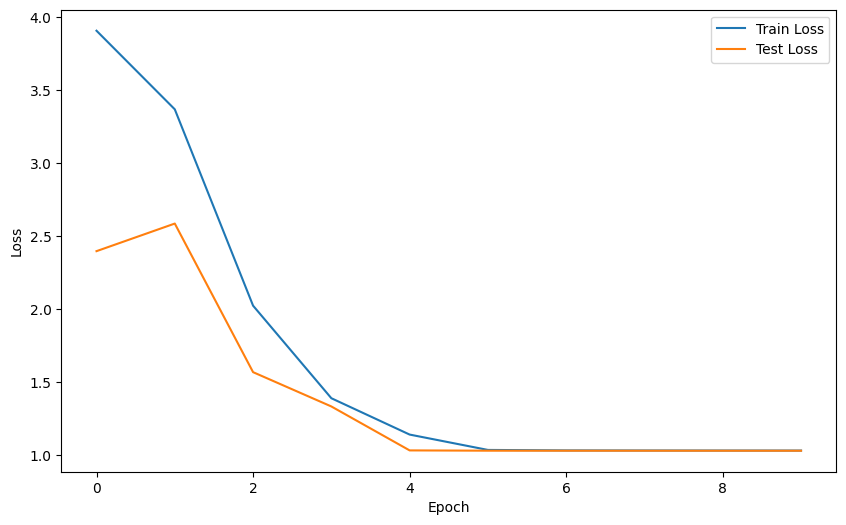

In [16]:
# Plot the train and test loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

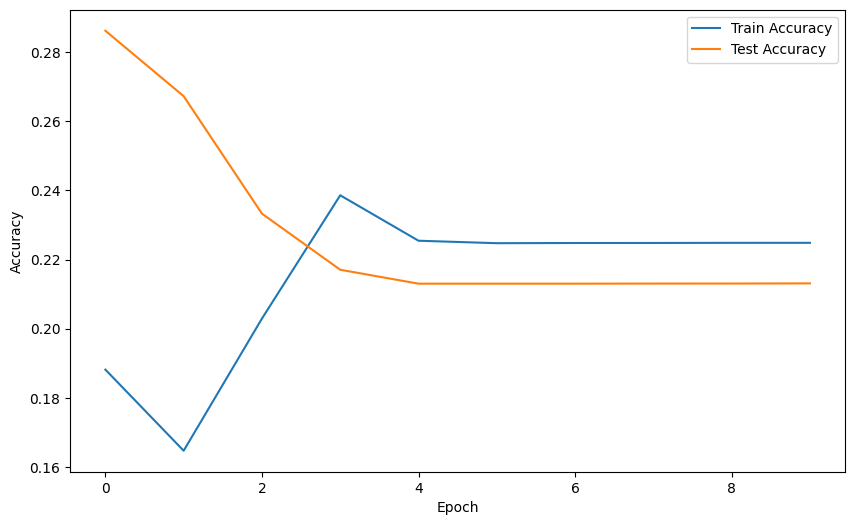

In [17]:
# Plot the train and test accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
import numpy as np
from scipy.io import wavfile
import tensorflow as tf

# Generate music using the trained model
def generate_music(model, length, num_notes):
    # Initialize the input sequence with random notes
    input_sequence = np.random.randint(0, num_notes, size=(1, length))
    
    # Generate music step by step
    for _ in range(length):
        # Predict the next note probabilities
        predictions = model.predict(input_sequence)
        
        # Apply softmax activation to convert logits to valid probabilities
        probabilities = tf.nn.softmax(predictions[0][-1]).numpy()
        
        # Sample the next note based on the predicted probabilities
        next_note = np.random.choice(num_notes, p=probabilities)
        
        # Append the next note to the input sequence
        input_sequence = np.concatenate([input_sequence[:, 1:], [[next_note]]], axis=1)
    
    return input_sequence[0]

# Set the desired length of the generated music (in number of notes)
generated_length = 500

# Set the number of unique notes in the dataset
num_notes = 128

# Generate music using the trained model
generated_sequence = generate_music(model, generated_length, num_notes)

# Convert the generated sequence to audio
sample_rate = 44100  # Sample rate of the audio (in Hz)
duration = 0.5  # Duration of each note (in seconds)

audio = np.zeros(generated_length * int(sample_rate * duration))
for i, note in enumerate(generated_sequence):
    if note > 0:  # Ignore rests (0)
        note_freq = 440 * 2**((note - 69) / 12)  # Convert MIDI note number to frequency
        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        audio[i * int(sample_rate * duration):(i + 1) * int(sample_rate * duration)] = np.sin(2 * np.pi * note_freq * t)

# Save the generated audio as a WAV file
wavfile.write("generated_music.wav", sample_rate, audio.astype(np.float32))
print("Generated audio saved as: generated_music.wav")

1/1 [==============================] - 0s 59ms/step
Generated audio saved as: generated_music.wav
